In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import sys
sys.path.append("/mnt/home2/dlongo/eegML/VQ-VAE-master/")
sys.path.append("/mnt/home2/dlongo/eegML/tsy935/RubinLab_neurotranslate_eeg-master/eeg/")
from vq_vae.auto_encoder import *
from data.data_utils import *
from data.data_loader import SeizureDataset
from constants import *
import math

In [42]:
def normalize(batch):
    batch = batch - batch.mean()
    batch = batch / batch.std()
    batch = batch / np.abs(batch).max()
    return batch

In [105]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))
sigmoid_v = np.vectorize(sigmoid)

In [43]:
def view_sample(x):
    #input shape (3, s, s)
    if x.shape[2] != 3:
        x = x.T
    print("x shape", x.shape)
    assert(len(x.shape) == 3), "Input should be three dimensional"
    assert(x.shape[2] == 3), "input should have three channels"
    imgplot = plt.imshow(x)
    

In [87]:
denoiser = VQ_CVAE(128, k=512, num_channels=3)
denoiser.load_state_dict(torch.load("/mnt/home2/dlongo/eegML/VQ-VAE-master/vq_vae/saved_models/train-cp.pt"))

In [88]:
seizure_file = TRAIN_SEIZURE_FILE
train_dataset = SeizureDataset(seizure_file, num_folds=5, split='train')
train_loader = data.DataLoader(dataset=train_dataset,
                                    shuffle=True,
                                    batch_size=4)
    

file dir:/mnt/home2/dlongo/eegML/tsy935/RubinLab_neurotranslate_eeg-master/eeg/data/trainSet_seizure_files.txt
/mnt/home2/dlongo/input/nonOverlap/train_features.h5


In [89]:
original = train_dataset[0][0].clone().view(-1, 3, 224, 224)
modified = train_dataset[0][0].clone().view(-1, 3, 224, 224)

In [90]:
modified.shape

torch.Size([9, 3, 224, 224])

In [91]:
modified = modified.cuda()
denoiser.cuda()

VQ_CVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ResBlock(
      (convs): Sequential(
        (0): ReLU()
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ResBlock(
      (convs): Sequential(
        (0): ReLU()
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2)

In [92]:
for i in range(0, modified.shape[0], 2):
    modified[i:i+2] = denoiser(modified[i:i+2])[0]

In [93]:
modified = modified.cpu()

In [94]:
modified.shape

torch.Size([9, 3, 224, 224])

In [95]:
if type(modified) != np.ndarray:
    modified = modified.detach().numpy()
if type(original) != np.ndarray:
    original = original.detach().numpy()

x shape (224, 224, 3)


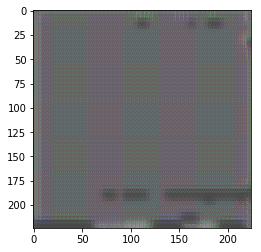

In [112]:
view_sample(sigmoid_v(modified[7]))

In [97]:
original_norm = normalize(original)

x shape (224, 224, 3)


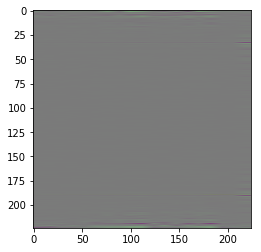

In [113]:
view_sample(sigmoid_v(original_norm[7]))